# ME5406 Project 1(Chua HongWei A0074741E)

This is the my code submission for ME5406 Project 1 (The Froze Lake Problem and Variations).

The cell is arranged in the way shown below:
- [1. Frozen Lake Environment](#1.-Frozen-Lake-Environment) -The first cell creates the Frozen Lake environment for 4x4 and 10x10 grid world. It contained FrozenEnv class which generates the environment and various visualization method that is used in this project.
- [2. RL Algorithm](#2.-RL-Algorithm) -All RL algorithm are created as function here with 2.1 Monte Carlo Control without Exploring Start, 2.2 SARSA, and 2.3 Q-learning.
- [3. Running RL Algorithm on 4x4](#3.-Running-RL-Algorithm-on-4x4) - This section display hyperparameters that is used to run all three RL algorithm on 4x4, and the results of all three RL algorithm run on 4x4 gridworld.
- [4. Running RL Algorithm on 10x10](#4.-Running-RL-Algorithm-on-10x10) - This section display hyperparameters that is used to run two RL algorithm on 10x10, and the results of two RL algorithm run on 10x10 gridworld.

### Python Packages version

- numpy      --> 1.20.3
- matplotlib --> 3.4.2
- gym        --> 0.19.0
- seaborn    --> 0.11.2
- tqdm       --> 4.62.2

Uncomment and run the cell below to install python packages if it is not available on the machine or the version does not match the version stated above.

In [1]:
# !pip install gym

In [2]:
# !pip install seaborn

In [3]:
# !pip install tqdm

## 1. Frozen Lake Environment

In [4]:
# Standard Import
import numpy as np
import gym
from gym import spaces
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

# Manually defined map in dictionary with the abbriviation shown below. (0 for 4x4, 1 for 10x10)
# R: Robot, E: Empty, H: Hole, F: Frisbee

map_type = {0: [['R','E','E','E'],
                ['E','H','E','H'],
                ['E','E','E','H'],
                ['H','E','E','F']],
            
            1: [['R','H','E','E','E','E','H','E','H','E'],
                ['E','E','E','H','H','E','H','E','E','E'],
                ['E','H','E','E','E','E','E','E','E','H'],
                ['E','E','E','H','E','E','E','H','E','E'],
                ['H','E','E','H','H','E','E','E','E','H'],
                ['E','E','E','E','E','E','H','E','E','E'],
                ['E','H','E','E','E','E','H','E','E','H'],                
                ['E','H','E','H','E','E','E','E','H','E'],
                ['E','E','E','H','H','E','E','E','E','E'],
                ['H','E','E','E','E','E','E','H','E','F']],
            }

# Setting random seed to 101 for consistent result
random.seed(101)

# Creating Environment
class FrozenEnv(gym.Env):

    def __init__(self,map_no):
        
        """Define basic map, initial state and action parameters

        Args:
        map_no: 0 for 4x4 map, 1 for 10x10 map

        """
    
        map_choice = map_type[map_no]
        
        # Converting map input to array
        self.map = np.asarray(map_choice,dtype='O')
        
        # Extract row and column from shape for future use
        self.n_row,self.n_col = n_row,n_col = self.map.shape
        
        size = n_col*n_row
        
        # Define observation space. 16 for 4x4 gridworld, 100 for 10x10 gridworld
        self.observation_space = spaces.Discrete(size)
        
        # Define action using gym algorithm
        self.action_space = spaces.Discrete(4)
        
        # Action choices for agent in the form of coordinates
        self.actions_dict = {0: (-1,  0),  # Up
                             1: ( 1,  0),  # Down
                             2: ( 0, -1),  # Left
                             3: ( 0,  1)   # Right
                            }
        
        # Define initial state
        self.state = 0
        
    def get_robot_xy(self):
        
        """Get agent x,y coordinates from state

        Returns:
        x: x-coordinates of agent
        y: y-coordinates of agent

        """
        
        x = self.state // self.n_row # get agent state x-coordinate
        y = self.state % self.n_col  # get agent state y-coordinate
        
        return x,y
        
    def step(self, action):
        
        """Take a step

        Args:
        action: Input an action

        Returns:
        state: Next state of agent after taking the action
        reward: Reward for completing the action
        done: True if the next state is terminal

        """
        
        # dx and dy are changes to coordinate system for x and y coordinates of current states based on action taken
        dx = self.actions_dict[action][0]
        dy = self.actions_dict[action][1]
        
        # Apply action and calculate the new_state, new_state x and y coordinates for future use
        current_state_x , current_state_y = self.get_robot_xy() 
        new_state_x = current_state_x + dx
        new_state_y = current_state_y + dy
        
        # Calculate new_state value using it's x and y coordinates
        new_state = new_state_x * self.n_col + new_state_y 

        # Initialise reward and done
        reward = 0
        done = False
        
        # Keep agent in the gridworld
        if not (0 <= new_state_x < self.n_col and 0 <= new_state_y < self.n_row):
            
            reward = 0
        
        # Reach 'Hole', Terminal State
        elif self.map[new_state_x][new_state_y] == 'H':
            
            reward = -1
            self.state = new_state
            done = True
            
        # Reach 'Frisbee', Terminal State
        elif self.map[new_state_x][new_state_y] == 'F':
        
            reward = 1
            self.state = new_state
            done = True
        
        # Reach 'Robot' or 'Empty'
        else:
        
            reward = 0
            self.state = new_state
        
        # Return step information
        return self.state, reward, done
        
    def reset(self):
        
        """Reset state to the starting position

        Returns:
        state: Starting position of the agent

        """
        
        # Initialize state to zero upon reset
        self.state = 0
        
        return self.state
    
    def render_heatmap_4x4(self,prob_table,qtable): 
        
        """For display of optimal policy for 4x4 map

        Args:
        qtable: Final qtable generated after all episodes

        """    
        
        # Get the best policy from prob_table
        policy = [np.argmax(prob_table[s]) for s in range(self.observation_space.n)]
        
        # Get the value function or q value from prob_table
        value_func = [max(qtable[s]) for s in range(self.observation_space.n)]
        
        # Creating heatmap as a simulation of optimal policy for the trained agent
        grid = 4
        plt.figure(figsize=(11,9))
        cmap = sns.diverging_palette(230, 30, as_cmap=True)
        reshaped=np.reshape(value_func,(grid,grid))
        sns.heatmap(reshaped, cmap=cmap, vmax=1.1,xticklabels=False,yticklabels=False,
                    square=True,linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt="f")
        
        # Indicate the unicode character on the heatmap 
        # Arrow for policy direction, cross for hole, crown for frisbee
        self.counter=0
        for j in range(self.n_col):
            for i in range(self.n_row):
                
                if (policy[self.counter] == 0 and self.map[j][i] == 'H'):
                    plt.text(i+0.45, j+0.75, u'\u2716', fontsize=20)
                    
                elif (policy[self.counter] == 0 and self.map[j][i] == 'F'):
                    plt.text(i+0.45, j+0.75, u'\u2654', fontsize=20)
                
                elif policy[self.counter] == 0:
                    plt.text(i+0.45, j+0.75, u'\u2191', fontsize=20) # up

                elif policy[self.counter] == 1:
                    plt.text(i+0.45, j+0.75, u'\u2193', fontsize=20) # down

                elif policy[self.counter] == 2:
                    plt.text(i+0.45, j+0.75, u'\u2190', fontsize=20) # left

                elif policy[self.counter] == 3:
                    plt.text(i+0.45, j+0.75, u'\u2192', fontsize=20) # right
                    
                self.counter = self.counter+1

        plt.title('Optimal policy with Q values and directions')
        plt.show()
    
    def render_heatmap_10x10(self,prob_table,qtable): 
        
        """For display of optimal policy for 10x10 map

        Args:
        qtable: Final qtable generated after all episodes

        """  
        
        # Similar code as render_heatmap_4x4 with the difference of grid = 10 for 10x10 heatmap
        policy = [np.argmax(prob_table[s]) for s in range(self.observation_space.n)]
        value_func = [max(qtable[s]) for s in range(self.observation_space.n)]
        grid = 10
        plt.figure(figsize=(22,18))
        cmap = sns.diverging_palette(230, 30, as_cmap=True)
        reshaped=np.reshape(value_func,(grid,grid))
        sns.heatmap(reshaped, cmap=cmap, vmax=1.1,xticklabels=False,yticklabels=False,
                    square=True,linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt="f")
        
        self.counter=0
        for j in range(self.n_col):
            for i in range(self.n_row):
                
                if (policy[self.counter] == 0 and self.map[j][i] == 'H'):
                    plt.text(i+0.4, j+0.75, u'\u2716', fontsize=20)
                    
                elif (policy[self.counter] == 0 and self.map[j][i] == 'F'):
                    plt.text(i+0.4, j+0.75, u'\u2654', fontsize=20)
                
                elif policy[self.counter] == 0:
                    plt.text(i+0.4, j+0.75, u'\u2191', fontsize=20) # up

                elif policy[self.counter] == 1:
                    plt.text(i+0.4, j+0.75, u'\u2193', fontsize=20) # down

                elif policy[self.counter] == 2:
                    plt.text(i+0.4, j+0.75, u'\u2190', fontsize=20) # left

                elif policy[self.counter] == 3:
                    plt.text(i+0.4, j+0.75, u'\u2192', fontsize=20) # right
                    
                self.counter = self.counter+1

        plt.title('Optimal policy with Q values and directions')
        plt.show()
    
    def ini_qtable(self):
        
        """Initialize all required table for RL algorithm

        Returns:
        prob_table (dict): Policy table for all action for each state. 
                    Used to calculate epsilon soft and epsilon greedy value
                    Format: {0: [0.25,0.25,0.25,0.25]....}
        qtable: Initial Q table for RL algorithm. 
                Numpy array that is initialise with all zero values with a shape of (16,4) for 4x4 map, (100,4) for 10x10 map
        returns_table (dict): Store G value calculated from monte carlo control method
                       Format: {(0,0): [0,0,0,0]....}    

        """  
        
        # Get state size and action size for creation of table
        state_size = self.observation_space.n
        action_size = self.action_space.n
        
        # Initialize q-table, returns table and policy table
        qtable = np.zeros((state_size,action_size))
        returns_table = {(i, j):list() for i in range(state_size) for j in range(action_size)}
        prob_table = {i:[1/action_size,1/action_size,1/action_size,1/action_size] for i in range(state_size)}
        
        return prob_table,qtable,returns_table
    
    def run_episode_with_policy(self,prob_table):
        
        """Method to run an episode with policy 
        
        Args:
        prob_table: Policy table generated during that episode
        
        Returns:
        success: Return True if episode is success, i.e. robot reach frisbee

        """  
        
        # Initialize all value for test run of generated policy
        state = self.reset()
        done = False
        success = False
        
        # Loop through one episode based on policy table generated
        while not done:
            
            # Take random action based on policy table
            action = np.random.choice(4,p=prob_table[state])
            
            # Get the outcome state and done value
            new_state,_,done = self.step(action)
            
            # Update the state value with the new_state value obtained from step(action).
            # Get the new_state x and y coordinates
            state = new_state
            new_state_x , new_state_y = self.get_robot_xy() 
          
            # Terminate the while loop if the policy show out of bound from grid world
            if not (0 <= new_state_x < self.n_col and 0 <= new_state_y < self.n_row):
                
                done = True
            
            # Terminate the while loop if the policy show to reach robot
            elif self.map[new_state_x][new_state_y] == 'R':
                
                done = True

            # Terminate the while loop if the policy show to reach hole
            elif self.map[new_state_x][new_state_y] == 'H':

                done = True
            
            # Terminate the while loop if the policy show to reach frisbee. Return success to indicate a complete episode
            elif self.map[new_state_x][new_state_y] == 'F':

                done = True
                success = True
            
            # Continue the while loop if agent is at empty 
            elif self.map[new_state_x][new_state_y] == 'E': 
                
                done = False
            
        return success
    
    def render_episode_completed(self,episode_completed_montecarlo,episode_completed_sarsa,episode_completed_qlearning,total_episodes):

        """Plot graph of episode vs count of success episode 
        
        Args:
        episode_completed_montecarlo: List of completed episode for MonteCarlo algorithm
        episode_completed_sarsa     : List of completed episode for SARSA algorithm
        episode_completed_qlearning : List of completed episode for Q-learning algorithm
        total_episodes              : Total episodes

        """  
        
        # List of episodes that reach frisbee
        x1 = episode_completed_montecarlo
        x2 = episode_completed_sarsa
        x3 = episode_completed_qlearning

        y = total_episodes
        
        # Plot of simple line graph 
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(x1)
        ax.plot(x2)
        ax.plot(x3)
        ax.set(title = "Episode vs Cumulative Number of Complete Episode",
               xlabel = "Cumulative Number of Complete Episode",
               ylabel = "Episode")
        ax.grid()
        ax.legend(['MonteCarlo','SARSA','Q-learning'])
        plt.show()
    

## 2. RL Algorithm

### 2.1 Monte Carlo Control without Exploring Start

In [5]:
# Setting random seed to 101 for consistent result
random.seed(101)

def montecarlo_episode(env,gamma,prob_table):
    
    """Create a random sampling episode for montecarlo calculation
    
    Args:
    env       : Environment to run this algorithm
    gamma     : Discount factor
    prob_table: Initialize prob_table taken from Frozenlake class
    
    Returns:
    episode_list (list): List of state action pair(tuple) in each episode
    reward_list (list) : List of reward for each action in each episode
    
    """
    
    # Reset the environment        
    state = env.reset()
    step = 0
    done = False
    
    # Create an empty episode list and reward list
    episode_list,reward_list = [],[]
    
    # Create a while loop. Keep looping until done is false
    while not done:

        step += 1
        
        # Take random action based on policy table
        action = np.random.choice(4, p=prob_table[state]) 

        # Get the outcome state, reward for completing the action and done value
        new_state, reward, done = env.step(action)
        
        # Append current state and action taken as a tuple pair into episode list
        episode_list.append((state,action))
        
        # Append reward into reward list for G calculation later
        reward_list.append(reward)    
            
        # Move to new state
        state = new_state
        
        # If done (agent died) --> finish episode
        if done:
            break    
        
    return episode_list,reward_list
    
def run_montecarlo(env,total_episodes,epsilon,gamma,min_epsilon,decay_rate,qtable,returns_table,prob_table):
 
    """Run MonteCarlo control without exploring start
    
    Args:
    env           : Environment to run this algorithm
    total_episodes: Number of episodes to sample.
    epsilon       : Probability of selecting a random action (set between 0 and 1)
    gamma         : Discount factor (set between 0 and 1)
    min_epsilon   : Mininum epsilon value (for decaying epsilon)
    decay_rate    : Rate of decaying of epsilon value 
    qtable        : Initialize qtable taken from Frozenlake class
    returns_table : Initialize returns_table taken from Frozenlake class
    prob_table    : Initialize prob_table taken from Frozenlake class
    
    Returns:
    qtable           : Final qtable output from this function
    prob_table       : Final prob_table output from this function
    episode_completed: List of all the successful episodes
    
    """
    
    # Initialized variables
    epoch = 1
    episode_completed = []
    epsiode = 0
    
    for episode in tqdm(range(total_episodes)):
        
        # Run function monte_carlo episode to generate random sampling episode
        episode_list,reward_list = montecarlo_episode(env,gamma,prob_table)
        
        # Initialize return G
        G = 0
        
        # Loop each state-action pair in episode list & corresponding reward in inversed direction
        for i in reversed(range(len(episode_list))):
            
            # Calculate return for each state-action pair using corresponding reward
            G = reward_list[i] + gamma * G
            
            # Get state-action pair tuple starting from last element
            state_action = episode_list[i] 
            
            # Get state value & action value starting from last element by using tuple unpacking
            state,action = episode_list[i]
            
            # Check if state-action pair appear in episode list (first-visit), 
            # if no, append G into the return list with corresponding state-action pair as it is the first encounter of the state-action pair
            # if yes, assign the G value to the corresponding state-action pair as it is consider first-visit to the state
            # since we loop the episode list in reversed direction
            
            if not state_action in [(x[0], x[1]) for x in episode_list[0:i]]:
                if returns_table.get(state_action):
                    returns_table[state_action].append(G)
                    
                else:
                    returns_table[state_action] = [G] 
                    
                # Calculate the average return and assign to q-table with corresponding state and action
                q_mean = np.mean(returns_table[state_action])
                qtable[state_action] = q_mean
                
            # Epsilon-greedy method
            # If all q-table value is the same, greedy action is any random action, else greddy action is the
            # action with highest q-table value
        
            if np.all(qtable[state] == qtable[state][0]):
                
                greedy_action = np.random.choice(4)
        
            else:
            
                greedy_action = np.argmax(qtable[state])
            
            # Update the policy table based on greedy action
            
            for a in range(env.action_space.n):
                    
                if a == greedy_action:
                        
                    prob_table[state][a] = 1 - epsilon + (epsilon / env.action_space.n)
                        
                else:
                 
                    prob_table[state][a] = epsilon / env.action_space.n
        
        # Record each succesful episode
        episode_success = env.run_episode_with_policy(prob_table)
        
        if episode_success:
            
            episode_completed.append(epoch)
            
        else:
            
            pass
        
        epoch += 1
        
        # Linear decay of epsilon value
        epsilon = max(epsilon*decay_rate,min_epsilon)
        
        # Scheduled epsilon decay (uncomment if want to run a scheduled epsilon decay)
#         if (0.75*total_episodes < episode <= total_episodes):
#             epsilon = 0.1
#         elif (0.5*total_episodes < episode <= 0.75*total_episodes):
#             epsilon = 0.5
#         elif episode <= 0.5*total_episodes:
#             epsilon = 1
        
        episode += 1
                                                       
    return qtable,prob_table,episode_completed

### 2.2 SARSA

In [6]:
# Setting random seed to 101 for consistent result
random.seed(101)

def run_sarsa(env,total_episodes,epsilon,learning_rate,gamma,min_epsilon,decay_rate,qtable,prob_table):
    
    """Run SARSA
    
    Args:
    env           : Environment to run this algorithm
    total_episodes: Number of episodes to sample
    epsilon       : Probability of selecting a random action (set between 0 and 1)
    learning_rate : Learning rate of the algorithm (set between 0 and 1)
    gamma         : Discount factor (set between 0 and 1)
    min_epsilon   : Mininum epsilon value (for decaying epsilon)
    decay_rate    : Rate of decaying of epsilon value 
    qtable        : Initialize qtable taken from Frozenlake class
    returns_table : Initialize returns_table taken from Frozenlake class
    prob_table    : Initialize prob_table taken from Frozenlake class
    
    Returns:
    qtable           : Final qtable output from this function
    prob_table       : Final prob_table output from this function
    episode_completed: List of all the successful episodes
    
    """
    
    # Initialized variables
    epoch = 1
    episode_completed = []
    epsiode = 0

    for episode in tqdm(range(total_episodes)):
    
        # Reset the environment
        state = env.reset()
        step = 0
        done = False
        rewards = 0
        
        # Create a while loop. Keep looping until done is false
        while not done:
            
            # Take random action based on policy table
            action = np.random.choice(4, p=prob_table[state])

            # Get the outcome state, reward for completing the action and done value
            new_state, reward, done = env.step(action)
            
            # Find new action based on new state. Uniquely for SARSA
            new_action = np.random.choice(4, p=prob_table[new_state])

            # Update Q(s,a) = Q(s,a) + learning rate x [reward + gamma * Q(s',a') - Q(s,a)]
            qtable[state,action] = qtable[state,action] + learning_rate * ((reward + gamma * qtable[new_state,new_action]) - qtable[state,action])
            
            # Epsilon-greedy method
            # If all q-table value is the same, greedy action is any random action, else greddy action is the
            # action with highest q-table value
            
            if np.all(qtable[state] == qtable[state][0]):
                
                greedy_action = np.random.choice(4)
        
            else:
            
                greedy_action = np.argmax(qtable[state])
            
            # Update the policy table based on greedy action
            
            for a in range(env.action_space.n):
                    
                if a == greedy_action:
                        
                    prob_table[state][a] = 1 - epsilon + (epsilon / env.action_space.n)
                        
                else:
                 
                    prob_table[state][a] = epsilon / env.action_space.n

            # Move to new state
            state = new_state
            
            # If done (agent died) --> finish episode
            if done:
                break
        
        # Record each succesful episode
        episode_success = env.run_episode_with_policy(prob_table)
        
        if episode_success:
            
            episode_completed.append(epoch)
        
        else:
            
            pass
            
        epoch += 1
        
        # Linear decay of epsilon value
        epsilon = max(epsilon*decay_rate,min_epsilon)
        
        # Scheduled epsilon decay (uncomment if want to run a scheduled epsilon decay)
#         if (0.75*total_episodes < episode <= total_episodes):
#             epsilon = 0.1
#         elif (0.5*total_episodes < episode <= 0.75*total_episodes):
#             epsilon = 0.5
#         elif episode <= 0.5*total_episodes:
#             epsilon = 1
        
        episode += 1
    
    return qtable,prob_table,episode_completed

### 2.3 Q-learning

In [7]:
# Setting random seed to 101 for consistent result
random.seed(101)

def run_qlearning(env,total_episodes,epsilon,learning_rate,gamma,min_epsilon,decay_rate,qtable,prob_table):
    
    """Run Q-learning
    
    Args:
    env           : Environment to run this algorithm
    total_episodes: Number of episodes to sample
    epsilon       : Probability of selecting a random action (set between 0 and 1)
    learning_rate : Learning rate of the algorithm (set between 0 and 1)
    gamma         : Discount factor (set between 0 and 1)
    min_epsilon   : Mininum epsilon value (for decaying epsilon)
    decay_rate    : Rate of decaying of epsilon value 
    qtable        : Initialize qtable taken from Frozenlake class
    returns_table : Initialize returns_table taken from Frozenlake class
    prob_table    : Initialize prob_table taken from Frozenlake class
    
    Returns:
    qtable           : Final qtable output from this function
    prob_table       : Final prob_table output from this function
    episode_completed: List of all the successful episodes
    
    """
    
    # Initialized variables
    epoch = 1
    episode_completed = []
    episode = 0

    for episode in tqdm(range(total_episodes)):
    
        # Reset the environment
        state = env.reset()
        step = 0
        done = False
        rewards = 0
        
        # Create a while loop. Keep looping until done is false
        while not done:
            
            # Take random action based on policy table
            action = np.random.choice(4, p=prob_table[state])

            # Get the outcome state, reward for completing the action and done value
            new_state, reward, done = env.step(action)

            # Update Q(s,a) = Q(s,a) + learning rate x [reward + gamma * max Q(s',a) - Q(s,a)]
            qtable[state,action] = qtable[state,action] + learning_rate * ((reward + gamma * np.max(qtable[new_state])) - qtable[state,action])
            
            # Epsilon-greedy method
            # If all q-table value is the same, greedy action is any random action, else greddy action is the
            # action with highest q-table value
            
            if np.all(qtable[state] == qtable[state][0]):
                
                greedy_action = np.random.choice(4)
        
            else:
            
                greedy_action = np.argmax(qtable[state]) 
            
            # Update the policy table based on greedy action
            
            for a in range(env.action_space.n):
                    
                if a == greedy_action:
                        
                    prob_table[state][a] = 1 - epsilon + (epsilon / env.action_space.n)
                        
                else:
                 
                    prob_table[state][a] = epsilon / env.action_space.n

            # Move to new state
            state = new_state

            # If done (agent died) --> finish episode
            if done:
                break
        
        # Record each succesful episode
        episode_success = env.run_episode_with_policy(prob_table)
        
        if episode_success:
            
            episode_completed.append(epoch)
        
        else:
            
            pass
           
        epoch += 1
        
        # Linear decay of epsilon value
        epsilon = max(epsilon*decay_rate,min_epsilon)

#         # Scheduled epsilon decay (uncomment if want to run a scheduled epsilon decay)
#         if (0.75*total_episodes < episode <= total_episodes):
#             epsilon = 0.1
#         elif (0.5*total_episodes < episode <= 0.75*total_episodes):
#             epsilon = 0.5
#         elif episode <= 0.5*total_episodes:
#             epsilon = 1
        
        episode += 1
            
    return qtable,prob_table,episode_completed

## 3. Running RL Algorithm on 4x4

### 3.1 Hyperparameters for 4x4

Set the hyperparameters for 4x4 gridworld here

In [8]:
total_episodes = 2000
epsilon        = 1 
learning_rate  = 0.1       
gamma          = 0.95                        
min_epsilon    = 0.2    
decay_rate     = 0.999

### 3.2 First Visit MonteCarlo Control without Exploring Start

Run First Visit MonteCarlo Control without Exploring Start here. The policy will be displayed in heatmap. 

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1926.79it/s]


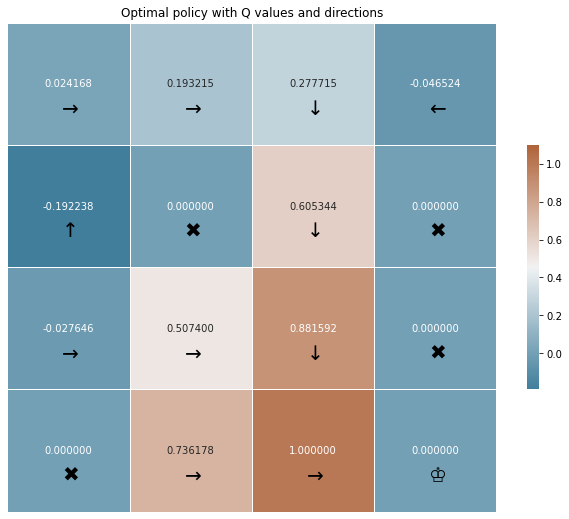

In [9]:
prob_montecarlo,qtable_montecarlo,returns_table_montecarlo = FrozenEnv(0).ini_qtable()
qtable_montecarlo,prob_montecarlo,episode_completed_montecarlo = run_montecarlo(FrozenEnv(0),
                                                                                total_episodes,
                                                                                epsilon,
                                                                                gamma,
                                                                                min_epsilon,
                                                                                decay_rate,
                                                                                qtable_montecarlo,
                                                                                returns_table_montecarlo,
                                                                                prob_montecarlo)
FrozenEnv(0).render_heatmap_4x4(prob_montecarlo,qtable_montecarlo)

### 3.3 Sarsa

Run SARSA here. The policy will be displayed in heatmap.

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2541.49it/s]


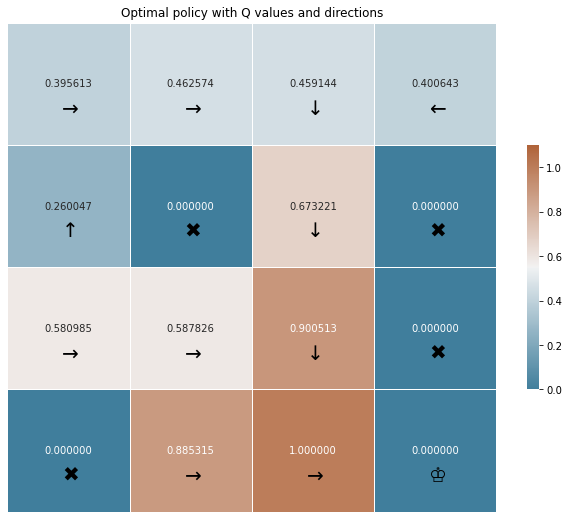

In [10]:
prob_sarsa,qtable_sarsa,_ = FrozenEnv(0).ini_qtable()
qtable_sarsa,prob_sarsa,episode_completed_sarsa = run_sarsa(FrozenEnv(0),
                                                            total_episodes,
                                                            epsilon,
                                                            learning_rate,
                                                            gamma,
                                                            min_epsilon,
                                                            decay_rate,
                                                            qtable_sarsa,
                                                            prob_sarsa)
FrozenEnv(0).render_heatmap_4x4(prob_sarsa,qtable_sarsa)

### 3.4 Q-learning

Run Q-learning here. The policy will be displayed in heatmap.

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 3863.68it/s]


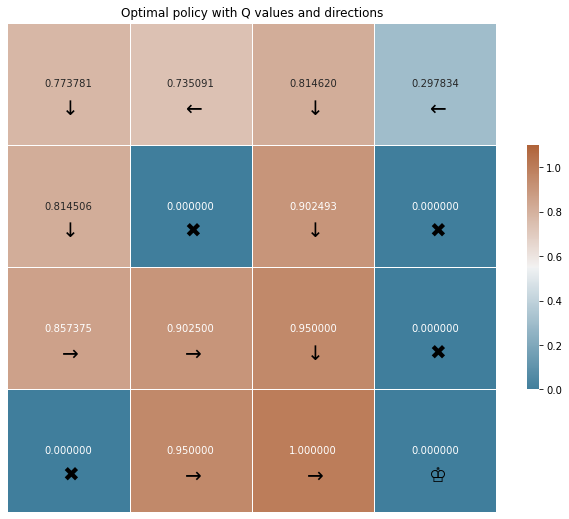

In [11]:
prob_qlearning,qtable_qlearning,_ = FrozenEnv(0).ini_qtable()
qtable_qlearning,prob_qlearning,episode_completed_qlearning = run_qlearning(FrozenEnv(0),
                                                              total_episodes,
                                                              epsilon,
                                                              learning_rate,
                                                              gamma,
                                                              min_epsilon,
                                                              decay_rate,
                                                              qtable_qlearning,
                                                              prob_qlearning)
FrozenEnv(0).render_heatmap_4x4(prob_qlearning,qtable_qlearning)

Comparison graph for three methods is shown here. 

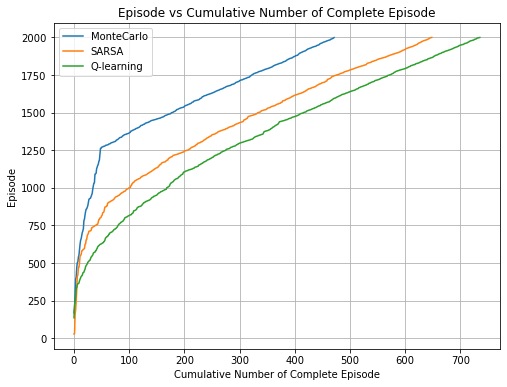

In [12]:
FrozenEnv(0).render_episode_completed(episode_completed_montecarlo,
                                      episode_completed_sarsa,
                                      episode_completed_qlearning,
                                      total_episodes)

## 4. Running RL Algorithm on 10x10

### 4.1 Hyperparameters for 10x10

Set the hyperparameters for 10x10 gridworld here

In [13]:
total_episodes = 50000
epsilon        = 1 
learning_rate  = 0.1      
gamma          = 0.99                       
min_epsilon    = 0.0001   
decay_rate     = 0.99999

### 4.2 Sarsa

Run SARSA here. The policy will be displayed in heatmap.

100%|███████████████████████████████████| 50000/50000 [00:14<00:00, 3460.00it/s]


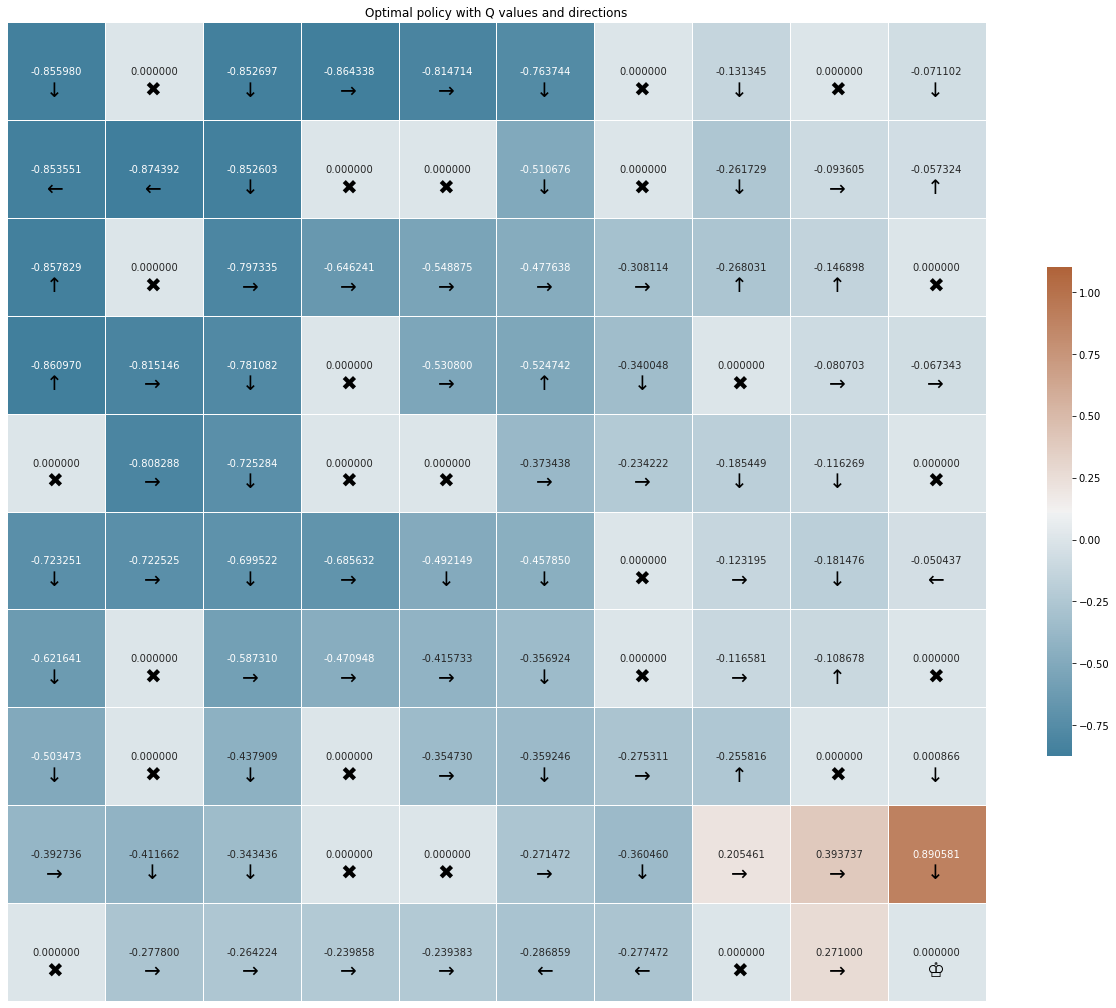

In [14]:
prob_sarsa,qtable_sarsa,_ = FrozenEnv(1).ini_qtable()
qtable_sarsa,prob_sarsa,episode_completed_sarsa = run_sarsa(FrozenEnv(1),
                                                  total_episodes,
                                                  epsilon,
                                                  learning_rate,
                                                  gamma,
                                                  min_epsilon,
                                                  decay_rate,
                                                  qtable_sarsa,
                                                  prob_sarsa)
FrozenEnv(1).render_heatmap_10x10(prob_sarsa,qtable_sarsa)

### 4.3 Q-learning

Run Q-learning here. The policy will be displayed in heatmap.

100%|███████████████████████████████████| 50000/50000 [00:10<00:00, 4978.27it/s]


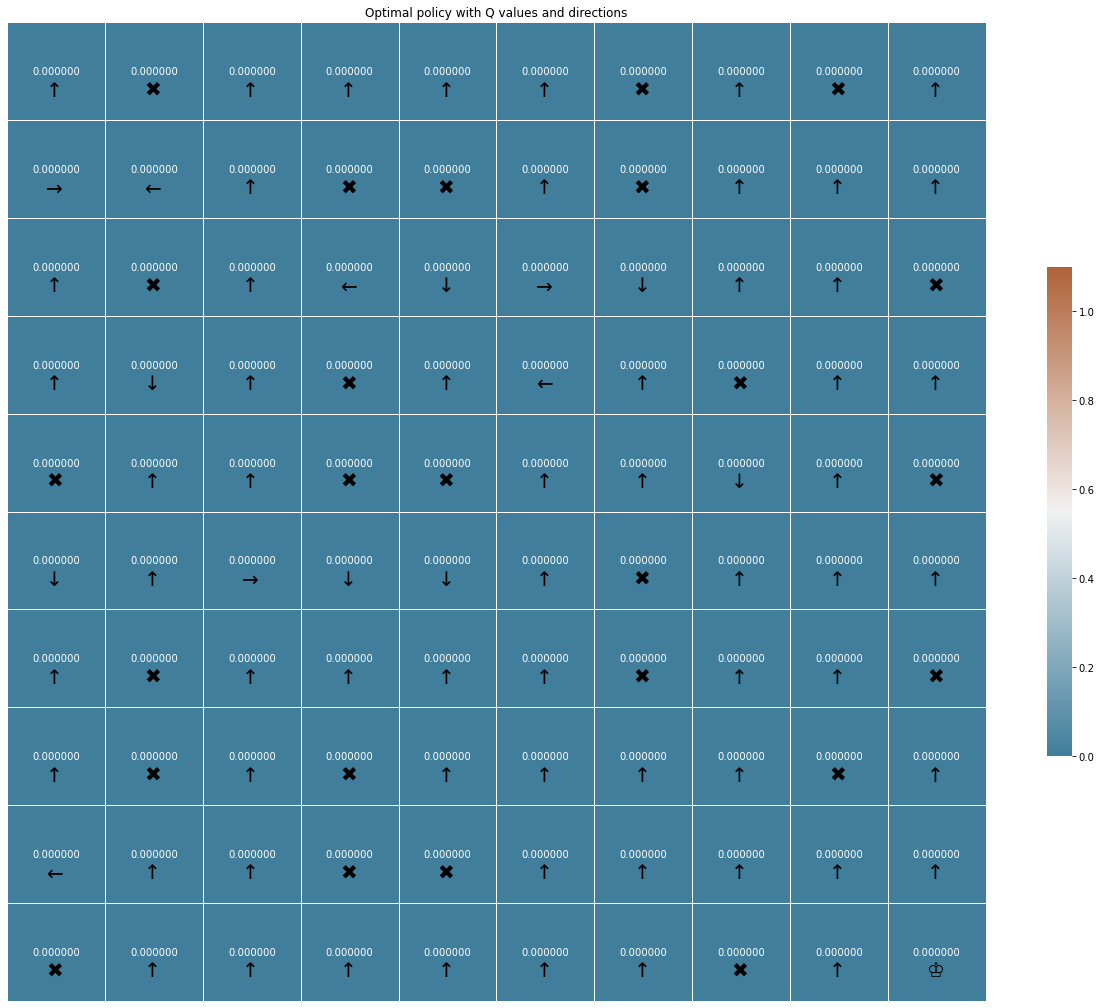

In [15]:
prob_qlearning,qtable_qlearning,_ = FrozenEnv(1).ini_qtable()
qtable_qlearning,prob_qlearning,episode_completed_qlearning = run_qlearning(FrozenEnv(1),
                                                                            total_episodes,
                                                                            epsilon, 
                                                                            learning_rate,
                                                                            gamma,
                                                                            min_epsilon,
                                                                            decay_rate,
                                                                            qtable_qlearning,
                                                                            prob_qlearning)
FrozenEnv(1).render_heatmap_10x10(prob_qlearning,qtable_qlearning)

Please refer my report for all other details including comparison of different methods in both grid world, effect of different hyperparameters and suggestions to improve the results. Thanks